# Booking.com Challenge - WebTour 2021 <br> ACM WSDM workshop
4th place solution for [Booking.com](https://www.bookingchallenge.com/final-leaderboard-results)'s next destination
recommendation challenge.

[Documentation](https://mbaigorria.github.io/booking-challenge-2021-recsys) |
[Github](https://github.com/mbaigorria/booking-challenge-2021-recsys) |
[Colab](https://colab.research.google.com/drive/1202KKmzrIZY0t9dhOoA5zINPI0qkx4lX)

#### Recommended Citation:

```
@inproceedings{DOI_CODE,
 author = {Baigorria Alonso, Martín},
 booktitle = {ACM WSDM Workshop on Web Tourism (WSDM WebTour’21)},
 howpublished = {\url{https://mbaigorria.github.io/booking-challenge-2021-recsys}},
 title = {Many-To-Many RNN Model For Session-Aware Recommender Systems},
 year = {2021}
}
```

In [ ]:
!git clone git@github.com:mbaigorria/booking-challenge-2021-recsys.git

In [ ]:
%cd booking-challenge-2021-recsys/
!bash get_resources.sh
!pip install -e .

/content/booking-challenge-2021-recsys
--2021-02-20 14:56:36--  https://shoutout.wix.com/so/c4NRCVgeV/c?w=OUERqDAyWlD4w8xMugq00JMzsLO6ZoB9fQcWfVv409k.eyJ1IjoiaHR0cHM6Ly8wMzUxMDVmNy1hZTMyLTQ3YjYtYTI1Yi04N2FmNzkyNGM3ZWEudXNyZmlsZXMuY29tL2FyY2hpdmVzLzMwOTFiZV84Mzc4NGYzMzA1NWM0NzkxYWUyYjY4ODdlMTFkZGYwOS56aXA_ZG49QktOR3Rlc3RkYXRhV1NETTIwMjEuemlwIiwiciI6IjAzMzQzYjU3LTQ5MGYtNDk3OS02NGFjLTZjZTJlYjBiZDU0NyIsIm0iOiJtYWlsIiwiYyI6IjRlNjU2ZjFhLTEzOTgtNDRiNy04OWJiLTRhNjc5Mjc1MGExYSJ9
Resolving shoutout.wix.com (shoutout.wix.com)... 185.230.61.101
Connecting to shoutout.wix.com (shoutout.wix.com)|185.230.61.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://035105f7-ae32-47b6-a25b-87af7924c7ea.usrfiles.com/archives/3091be_83784f33055c4791ae2b6887e11ddf09.zip?dn=BKNGtestdataWSDM2021.zip [following]
--2021-02-20 14:56:37--  https://035105f7-ae32-47b6-a25b-87af7924c7ea.usrfiles.com/archives/3091be_83784f33055c4791ae2b6887e11ddf09.zip?dn=BKNGtestdataWSDM2021.zip
Re

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging

from recsys import config
from recsys.dataset import build_dataset, get_training_set_from_dataset, \
    get_test_set_from_dataset, set_future_features, get_submission_set_from_dataset
from recsys.dataset_loader import get_dataset_and_dataloader, batches_to_device
from recsys.encoders import DatasetEncoder
from recsys.experiments import get_base_configuration, \
    get_model_performance_data, filter_results_table
from recsys.model_train import train_model_for_folds
from recsys.paths import get_path
from recsys.plot import get_plot_from_accuracy
from recsys.utils import get_distribution_by_pos, print_gpu_usage, get_final_submission

INFO:root:Using GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-d1b260b2-0a63-8081-d5d4-fbc86a7a898c)


# Build and encode dataset

In [ ]:
dataset = build_dataset(reserved_obs=30000)
de = DatasetEncoder(config.FEATURES_TO_ENCODE)
de.fit_transform(dataset)
set_future_features(dataset)

submission_set = get_submission_set_from_dataset(dataset)

# keep only observations before the last visit
dataset = dataset[~dataset.next_city_id.isna()]

# split training and test set from dataset
train_set = get_training_set_from_dataset(dataset)
test_set = get_test_set_from_dataset(dataset)

logging.info(f"Training set: {train_set.shape}")
logging.info(f"Test set: {test_set.shape}")
logging.info(f"Dataset: {dataset.shape}")

logging.info(get_distribution_by_pos(dataset=dataset,
                                      train_set=train_set[train_set.train == 1],
                                      test_set=test_set,
                                      submission=submission_set).head(10))

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Running LabelEncoder on columns
INFO:root:city_id: 39901
INFO:root:device_class: 3
INFO:root:affiliate_id: 3611
INFO:root:booker_country: 5
INFO:root:hotel_country: 195
INFO:root:checkin_year: 3
INFO:root:days_stay: 30
INFO:root:checkin_day: 7
INFO:root:checkin_month: 12
INFO:root:transition_days: 32
INFO:root:Training set: (1162101, 21)
INFO:root:Test set: (24354, 21)
INFO:root:Dataset: (1186492, 21)
INFO:root:     dataset  train_set  test_set  submission
1   0.000604   0.000816       NaN         NaN
2   0.113137   0.002713       NaN         NaN
3   0.397957   0.452025  0.454903    0.453101
4   0.203990   0.229277  0.224588    0.231369
5   0.113595   0.125860  0.128848    0.126560
6   0.066251   0.073781  0.0826

# Pre-load all batches to GPU

In [ ]:
_, dataset_loader = get_dataset_and_dataloader(
    train_set,
    features=config.FEATURES_EMBEDDING + ['next_city_id'],
    batch_size=config.BATCH_SIZE
)
dataset_batches_cuda = batches_to_device(dataset_loader)

print_gpu_usage(0)

  0%|          | 0/282628 [00:00<?, ?it/s]

INFO:root:Gen RAM Free: 20.5 GB | Proc size: 7.8 GB
INFO:root:GPU RAM Free: 14801MB | Used: 1359MB | Util   8% | Total 16160MB


# Train model

In [ ]:
# train model from best configuration
model_configuration = get_base_configuration()
model_hash = train_model_for_folds(dataset_batches_cuda,
                                    train_set,
                                    model_configuration,
                                    n_models=1)

INFO:root:Weights: 1
INFO:root:Training model 0962b86e for fold 0


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Epoch: 0, train loss: 7.7697, valid loss: 5.9697, accuracy@1: 0.1885, accuracy@4: 0.3736, time: 0:00:11
INFO:root:Epoch: 1, train loss: 6.0877, valid loss: 5.3107, accuracy@1: 0.2133, accuracy@4: 0.4121, time: 0:00:10
INFO:root:Epoch: 2, train loss: 5.5727, valid loss: 4.9853, accuracy@1: 0.2294, accuracy@4: 0.4325, time: 0:00:10
INFO:root:Epoch: 3, train loss: 5.2689, valid loss: 4.7851, accuracy@1: 0.2379, accuracy@4: 0.4464, time: 0:00:10
INFO:root:Epoch: 4, train loss: 5.0568, valid loss: 4.6372, accuracy@1: 0.2451, accuracy@4: 0.4564, time: 0:00:10
INFO:root:Epoch: 5, train loss: 4.8936, valid loss: 4.5318, accuracy@1: 0.2507, accuracy@4: 0.4641, time: 0:00:10
INFO:root:Epoch: 6, train loss: 4.7635, valid loss: 4.4464, accuracy@1: 0.2605, accuracy@4: 0.4705, time: 0:00:10
INFO:root:Epoch: 7, train loss: 4.6564, valid loss: 4.3767, accuracy@1: 0.2616, accuracy@4: 0.4762, time: 0:00:10
INFO:root:Epoch: 8, train loss: 4.5616, valid loss: 4.3178, accuracy@1: 0.2656, accuracy

# Analyze model results

In [ ]:
results, acc_dict = get_model_performance_data(test_set, de)
filter_results_table(results)

  0%|          | 0/5588 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,model_type,recurrent_type,tie_embedding_and_projection,weight_type,accuracy@1,accuracy@4,accuracy@10,hash
0,MANY_TO_MANY,GRU,True,UNWEIGHTED,0.306013,0.519685,0.649606,0962b86e


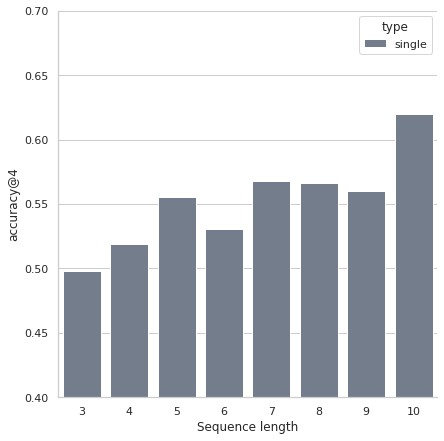

In [ ]:
get_plot_from_accuracy(single=acc_dict[(model_hash, 'single')])

# Build submission from single model

In [ ]:
get_final_submission(submission_set, model_hash, de)

  0%|          | 0/70662 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:Passed all sanity checks!
